# Analyze 42-qubit problem with 4 objective functions

In [1]:
# TODO: make installable!
import sys

sys.path += ['./../']

In [2]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from qamoo.utils.data_structures import ProblemGraphBuilder
from qamoo.utils.utils import evaluate_sample_objectives

import pygmo as pg

In [3]:
problem_folder = '/Users/wor/github-sandbox/qmoo/data/problems/42q/problem_set_42q_0s_4o_0/'

In [4]:
figures_folder = './../figures/'

In [5]:
# get objective graphs
num_objectives = 4
objective_graphs = [
        ProblemGraphBuilder.deserialize(
            problem_folder + f'problem_graph_{idx}.json')
        for idx in range(num_objectives)
    ]

# load reference point
reference_point = np.array(json.load(open(problem_folder + 'lower_bounds.json')))

## DCM Results

In [6]:
scaling = 1000

In [7]:
# read samples
with open(problem_folder + f'results/dcm/dcm_4o_{scaling}.sol', 'r') as f:
    s = f.read()
 
lines = s.split('\n')
solutions_x = ''
for line in lines:
    if line[:8] == 'Solution':
        solutions_x += line
solutions_x = solutions_x.split('Solution for NDP ')[1:]
solutions_x = [s.split(':')[1].replace(' =', '=')[1:-1] for s in solutions_x]
dcm_samples = []
for s in solutions_x:
    vvals = s.split(' ')
    x = []
    ids = []
    for v in vvals:
        v_ = v.split('=')
        v_name = v_[0].split('[')[0]
        v_val = int(np.round(float(v_[1])))
        if v_name[0] == 'n':
            ids += [int(v_name[2:])]
            x += [v_val]
    x = np.array(x)
    idx = np.argsort(ids)
    x = x[idx]
    dcm_samples += [x]
dcm_samples = np.array(dcm_samples)

In [8]:
# evaluate number of non-dominated points for HW
fvals = evaluate_sample_objectives(dcm_samples, objective_graphs)
print('#fvals  =', len(fvals))

#fvals  = 19390


In [9]:
# read samples
with open(problem_folder + f'results/dcm/dcm_4o_{scaling}.sol', 'r') as f:
    s = f.read()
# NDP 2058: 185 -3202 -20664 Time: 27.7169
lines = s.split('\n')
times = np.zeros(len(fvals))
for line in lines:
    if line[:4] == 'NDP ':
        s = line[4:].split(':')
        times[int(s[0])-1] = float(s[-1])

idx = np.argsort(times)
times = times[idx]
fvals = fvals[idx]

In [10]:
# ----------------------------------
# uncomment to run - requires pygmo
# ----------------------------------

# dcm_progress = {}
# num_steps = 100
# steps = np.array(np.round(np.linspace(0, len(times)-1, num_steps)), dtype=int)
# t = 0
# for i in tqdm(steps):
#     t = times[i]
#     f_hv = pg.hypervolume(-np.array(fvals)[:(i+1)])
#     hv = f_hv.compute(-reference_point)
#     dcm_progress[str(t)] = hv

# with open(problem_folder + f'results/dcm/dcm_4o_{scaling}_progress.json', 'w') as f:
#     json.dump(dcm_progress, f)

In [11]:
with open(problem_folder + f'results/dcm/dcm_4o_{scaling}_progress.json', 'r') as f:
    dcm_progress = json.load(f)

In [12]:
x_dcm = np.array([float(x_) for x_ in dcm_progress.keys()])
y_dcm = np.array(list(dcm_progress.values()))

## DPA Results

In [13]:
scaling = 1000

In [14]:
# read variables names
variable_names = []
variable_indices = []
variable_positions = []
cnt = 0
with open(problem_folder + 'results/dpa/dpa_variables.txt', 'r') as f:
    s = f.read()
    lines = s.split('\n')
    for l in lines:    
        if l[0] == 'n':
            variable_names += [l]
            variable_indices += [int(l[2:])]
            variable_positions += [cnt]
        cnt += 1
idx = np.argsort(variable_indices)
pos = np.array(variable_positions)[idx]

In [15]:
# read samples
with open(problem_folder + f'results/dpa/4o_{scaling}/dpa_4o_{scaling}_x.sol', 'r') as f:
    s = f.read()
 
lines = s.split('\n')
solutions_x = ''
for line in lines:
    solutions_x += line
solutions_x = [s.replace('[', '').replace(']', '') for s in solutions_x.split('][')]
print(len(solutions_x))
dpa_samples = []
for x in solutions_x:
    x = [int(np.round(float(x_))) for x_ in x.split(',')]
    dpa_samples += [np.array(x)[pos]]
dpa_samples = np.array(dpa_samples)

30313


In [16]:
# evaluate number of non-dominated points for HW
fvals = evaluate_sample_objectives(dpa_samples, objective_graphs)
print('#fvals  =', len(fvals))

#fvals  = 30313


In [17]:
# read samples
with open(problem_folder + f'results/dpa/4o_{scaling}/dpa_4o_{scaling}_progress.sol', 'r') as f:
    s = f.read()
    
times = [float(i) for i in s.split('\n')[:-1]]
t_start = -1
ts = []
num = []
for t in times:
    if t == t_start:
        num[-1] += 1
    else:
        t_start = t
        ts += [t]
        num += [1]

In [18]:
# ----------------------------------
# uncomment to run - requires pygmo
# ----------------------------------

# dpa_progress = {}
# num_steps = 100
# steps = np.array(np.round(np.linspace(0, len(times)-1, num_steps)), dtype=int)
# for i in tqdm(steps):
#     num_points = sum(num[:(i+1)])
#     f_hv = pg.hypervolume(-np.array(fvals)[:num_points])
#     hv = f_hv.compute(-reference_point)
#     dpa_progress[str(times[i])] = hv

# with open(problem_folder + f'results/dpa/dpa_4o_{scaling}_progress.json', 'w') as f:
#     json.dump(dpa_progress, f)

In [19]:
with open(problem_folder + f'results/dpa/dpa_4o_{scaling}_progress.json', 'r') as f:
    dpa_progress = json.load(f)

In [20]:
x_dpa = np.array([float(x_) for x_ in dpa_progress.keys()])
y_dpa = np.array(list(dpa_progress.values()))

## $\epsilon$-Constraint Method

In [21]:
num_eps_samples = 742081
num_c_samples = 1  # per eps sample
run_id = 0

In [22]:
with open(problem_folder + f'results/random_eps_constraint_{num_eps_samples}_samples_{num_c_samples}_shots_{run_id}/progress.json', 'r') as f:
    eps_progress = json.load(f)

In [23]:
x_eps = np.array(list(eps_progress.keys()))
y_eps = np.array(list(eps_progress.values()))

## MPS / HW Rresults

In [24]:
try:
    with open(problem_folder + 'time_records.json') as f:
        time_records = json.load(f)
    avg_times = {}
    for k in time_records:
        avg_times[k] = np.mean(time_records[k]['times'])
    print(avg_times)
except:
    print('no time records found!')

{'GWO': 0.4005819034576416, 'R_EPS': 0.026951215267181396, 'WS': 0.004020397663116455, 'B_R': 0.02031998872756958}


In [25]:
t_shot = 0.0001             # time per shot / sample
t_eps = avg_times['R_EPS']  # time per MIP / sample

In [26]:
# collect all QAOA results
mps_progress = {}
folder = Path(problem_folder + 'results/')
for f in os.scandir(folder):
    if f.is_dir():
        alg_name = f.path.split('/')[-1]
        if alg_name[:8] == 'qaoa_aer':
            try:
                mps_progress[alg_name] = json.load(open(f.path + '/progress.json'))
            except:
                pass

In [27]:
mps_results = []
for i in range(5):
    try:
        progress = mps_progress[f'qaoa_aer_simulator_matrix_product_state_v2_p_6_20000_samples_5000_shots_a_20_{i}']
        x_mps = sorted([int(t) for t in progress.keys()])
        mps_results += [list(progress.values())]
    except:
        print(f'no MPS results for ({i})')
mps_results = np.array(mps_results)

In [28]:
# determine maximum found HV
hv_max_eps = max(y_eps)
hv_max_dcm = max(y_dcm)
hv_max_dpa = max(y_dpa)

hv_max = max([hv_max_eps, hv_max_dcm, hv_max_dpa, np.max(mps_results)])
print(hv_max)

1266143.3493885607


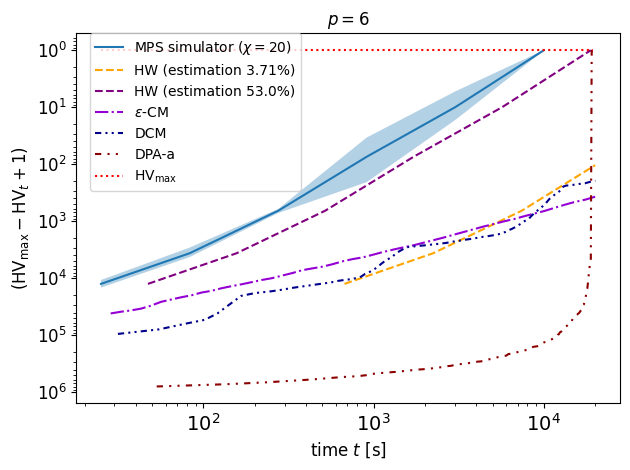

In [29]:
g = lambda y: hv_max + 1 - y

p = 6   
plt.title(rf'$p = {p}$')

# plot MPS results
ys = mps_results
y_mu = np.mean(ys, axis=0)
y_sigma = np.std(ys, axis=0)

factor = t_shot
x = np.array(x_mps)
plt.loglog(factor*x[:len(y_mu)], g(y_mu[:len(x)]), '-', label=r'MPS simulator ($\chi = 20$)')

colors = plt.cm.tab10(range(6))[::-1]
plt.fill_between(factor*x[:len(y_mu)], g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)

fidelity = 0.0371
x_pred = factor/fidelity*x[:len(y_mu)]
y_pred = g(y_mu[:len(x)])

x_pred_ = x_pred[:3]
y_pred_ = y_pred[:3]

# interpolate using power law to mimic "linear interpolation between points" in loglog plot
b = (np.log(y_pred[4]) - np.log(y_pred[3])) / (np.log(x_pred[4]) - np.log(x_pred[3]))
a = np.exp(np.log(y_pred[3]) - b * np.log(x_pred[3]))
x_pred_ = np.append(x_pred_, [20000])
y_pred_ = np.append(y_pred_, [a*20000**b])

plt.loglog(x_pred_, y_pred_, '--', color='orange', label='HW (estimation 3.71%)')
plt.fill_between(factor*x[:len(y_mu)], g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)

fidelity = 0.53
x_pred = factor/fidelity*x[:len(y_mu)]
y_pred = g(y_mu[:len(x)])

x_pred_ = x_pred[:3]
y_pred_ = y_pred[:3]

# interpolate using power law to mimic "linear interpolation between points" in loglog plot
plt.loglog(x_pred, y_pred, '--', color='purple', label='HW (estimation 53.0%)')
plt.fill_between(factor*x[:len(y_mu)], g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)


plt.xlabel(r'time $t$ [s]', fontsize=12)
plt.xticks(fontsize=14)

plt.yticks([1, 10, 100, 1000, 10000, 100000], fontsize=12)
plt.gca().invert_yaxis()

idx_eps = sum(t_eps * np.array(x_eps, dtype=float) < 25)
plt.loglog(t_eps * np.array(x_eps[idx_eps:], dtype=float), g(np.array(y_eps)[idx_eps:]), '-.', color='darkviolet', label=rf'$\epsilon$-CM')

idx_dcm = sum(x_dcm < 25)
dashdotdotted = (0, (3, 2, 1, 2, 1, 2))
plt.loglog(x_dcm[idx_dcm:], g(y_dcm[idx_dcm:]), linestyle=dashdotdotted, color='darkblue', label=rf'DCM')

idx_dpa = sum(x_dpa < 25)
dashdotdotted = (0, (3, 3, 1, 3, 1, 3))
plt.loglog(x_dpa[idx_dpa:], g(y_dpa[idx_dpa:]), linestyle=dashdotdotted, color='darkred', label=rf'DPA-a')

plt.loglog([25, max(x_dpa)], [1, 1], 'r:', label=r'$\text{HV}_{\text{max}}$')

plt.legend(loc=(0.025,0.575), fontsize=10)

plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)
plt.tight_layout()

plt.savefig(f'{figures_folder}42q_4o_mps_results.pdf')
plt.show()

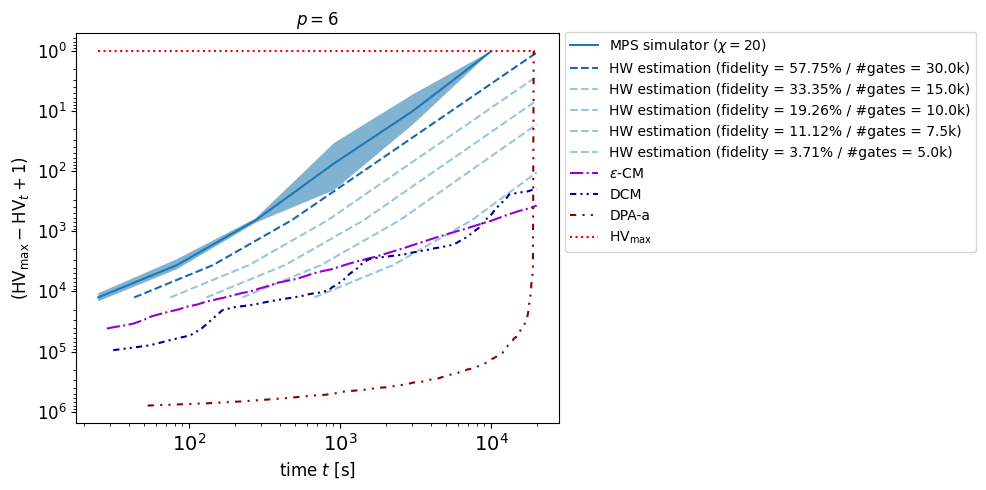

In [30]:
g = lambda y: hv_max + 1 - y

p = 6   
plt.figure(figsize=(10, 5))
plt.title(rf'$p = {p}$')

# plot MPS results
ys = mps_results
y_mu = np.mean(ys, axis=0)
y_sigma = np.std(ys, axis=0)

factor = t_shot
x = np.array(x_mps)
plt.loglog(factor*x[:len(y_mu)], g(y_mu[:len(x)]), '-', label=r'MPS simulator ($\chi = 20$)')

colors = plt.cm.tab10(range(6))[::-1]

plt.fill_between(factor*x[:len(y_mu)], g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)

fidelity = 0.0371

baseline_num_gates = 5000
num_gates = [5000, 7500, 10000, 15000, 30000]
orig_fid = 0.0371
for ng in num_gates[::-1]:
    
    # fidelity = 0.53
    exp = baseline_num_gates / ng
    fidelity = orig_fid**exp
    
    x_pred = factor/fidelity*x[:len(y_mu)]
    y_pred = g(y_mu[:len(x)])
    
    x_pred_ = x_pred[:3]
    y_pred_ = y_pred[:3]
    
    # interpolate using power law to mimic "linear interpolation between points" in loglog plot
    b = (np.log(y_pred[4]) - np.log(y_pred[3])) / (np.log(x_pred[4]) - np.log(x_pred[3]))
    a = np.exp(np.log(y_pred[3]) - b * np.log(x_pred[3]))
    x_pred_ = np.append(x_pred_, [20000])
    y_pred_ = np.append(y_pred_, [a*20000**b])

    color = plt.cm.Blues(int(np.round(ng / max(num_gates)))*100+100)
    
    plt.loglog(x_pred_, y_pred_, '--', color=color, label=f'HW estimation (fidelity = {np.round(100*fidelity, 2)}% / #gates = {np.round(ng/1000,1)}k)')
    plt.fill_between(factor*x[:len(y_mu)], g(np.min(ys, axis=0)), g(np.max(ys, axis=0)), edgecolor='none', facecolor=colors[p-1], alpha=0.125)


plt.xlabel(r'time $t$ [s]', fontsize=12)
plt.xticks(fontsize=14)

plt.yticks([1, 10, 100, 1000, 10000, 100000], fontsize=12)
plt.gca().invert_yaxis()

idx_eps = sum(t_eps * np.array(x_eps, dtype=float) < 25)
plt.loglog(t_eps * np.array(x_eps[idx_eps:], dtype=float), g(np.array(y_eps)[idx_eps:]), '-.', color='darkviolet', label=rf'$\epsilon$-CM')

idx_dcm = sum(x_dcm < 25)
dashdotdotted = (0, (3, 2, 1, 2, 1, 2))
plt.loglog(x_dcm[idx_dcm:], g(y_dcm[idx_dcm:]), linestyle=dashdotdotted, color='darkblue', label=rf'DCM')

idx_dpa = sum(x_dpa < 25)
dashdotdotted = (0, (3, 3, 1, 3, 1, 3))
plt.loglog(x_dpa[idx_dpa:], g(y_dpa[idx_dpa:]), linestyle=dashdotdotted, color='darkred', label=rf'DPA-a')

plt.loglog([25, max(x_dpa)], [1, 1], 'r:', label=r'$\text{HV}_{\text{max}}$')

plt.legend(loc=(1.0125,0.44), fontsize=10)

plt.ylabel(r'$(\text{HV}_{\text{max}} - \text{HV}_t + 1)$', fontsize=12)
plt.tight_layout()

plt.savefig(f'{figures_folder}42q_4o_mps_results_roadmap.pdf')
plt.show()